Dimensionality reduction
========

In [1]:
import numpy as np
import pandas as pd
import glob, os, sys, warnings, os.path, math, time
# warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from metric_learn import LMNN, NCA, LFDA, Covariance, MetricEvolution, NeuralNetworkTransformer, FullMatrixTransformer
from metric_learn import ITML_Supervised, SDML_Supervised, LSML_Supervised, RCA_Supervised
ME = MetricEvolution

%matplotlib inline
from plotting.plots import *
import pylab as plb
import matplotlib
import matplotlib.pyplot as plt
import brewer2mpl

datasetsDirectory = 'datasets'
resultsDirectory = 'datasets-results-dim-reduction'
graphsDirectory = 'img/dim-reduction'

if not os.path.exists(resultsDirectory):
    os.makedirs(resultsDirectory)
    
if not os.path.exists(graphsDirectory):
    os.makedirs(graphsDirectory)

np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

import pickle
def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(resultsDirectory+'/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
import glob, os

datasets = []
for file in glob.glob("{}/*.csv".format(datasetsDirectory)):
    datasets.append(file)
datasets.sort()

for x in datasets:
    print(x, pd.read_csv(x, sep=',', skiprows=1, header=0).shape)

datasets/balance-scale.csv (625, 5)
datasets/breast-cancer-wisconsin.csv (699, 10)
datasets/digits10.csv (1797, 65)
datasets/digits6.csv (1083, 65)
datasets/ionosphere.csv (351, 35)
datasets/iris.csv (150, 5)
datasets/letters.csv (20000, 17)
datasets/mice-protein.csv (1080, 78)
datasets/mnist.csv (70000, 785)
datasets/ofaces.csv (400, 4097)
datasets/pima-indians-diabetes.csv (768, 9)
datasets/sonar.csv (208, 61)
datasets/soybean-large.csv (307, 36)
datasets/wine.csv (178, 14)


In [3]:
def makeGraphBuilder(datasetName, X, y, perRow=4):
    traces = []
    models = []
    scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=False)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    def add(methodName, method, params):
        filename = '{}/{}__{}.pkl'.format(resultsDirectory, datasetName, methodName)
        if os.path.exists(filename):
            print('skipping {}, already exists'.format(methodName))
            return
        
        model = method(**params)
        model.set_params(**params)
        models.append(model)

        try:
            if callable(getattr(model, 'transform', None)): # TSNE cant transform
                Xt_train = model.fit_transform(X_train, y_train)
                Xt_test = model.transform(X_test)
            else:
                Xt = model.fit_transform(np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)))
                l = len(X_train)
                Xt_train, Xt_test = Xt[:l], Xt[l:]

            knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
            knn.fit(Xt_train, y_train)
            score = knn.score(Xt_test, y_test)
            wrong = knn.predict(Xt_test) != y_test

            data = {
                'score': score,
                'X_train': Xt_train,
                'y_train': y_train,
                'X_test': Xt_test,
                'y_test': y_test,
                'wrong': wrong,
            }
            save_obj(data, filename)
        except ValueError:
            raise

    return add

def P(methods):
    def c(**kwargs):
        return Pipeline([(x.__name__.lower(),x()) for x in methods])
    return c

In [4]:
for filename in datasets[0:]:
    results = []
    datasetName = filename[len(datasetsDirectory)+1:-4]
    
    data = pd.read_csv(filename, sep=',', skiprows=1, header=0)
    y = data['class']
    X = data.drop(['class'], axis=1).values

    le = LabelEncoder()
    y = le.fit_transform(y)
    
    g = makeGraphBuilder(datasetName, X, y, perRow=3)
    
    defaults = {
        'transformer':'neuralnetwork',
        't__layers':(2,),
        
        'n_gen': 3,
        'class_separation': True,
        'verbose': False,
        'random_state': 41,
    }

    print(datasetName)
    
    start = time.clock()
    
    g('pca', PCA, {'n_components':2})
    g('tsne', TSNE, {'n_components':2}) # , 'perplexity':50
    g('lfda', LFDA, {'dim':2, 'k':2})
    g('cmaes', ME, {'t__n_components':2})
    
#     end = time.clock()
#     print(end - start)
#     start = time.clock()
    
#     g(ME, {**defaults, 'classifier':'knn','c__n_neighbors':1,'c__n_jobs':-1,'c__weights':'uniform'})
#     g(ME, {**defaults, 'classifier':'svc',})
#     g(ME, {**defaults, 'classifier':'lsvc','c__dual':False,})
#     g(ME, {**defaults, 'transformer':NeuralNetworkTransformer(layers=(2,2,), activation='tanh'), 'c__n_neighbors':1, })
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,2,)), 'n_neighbors':1, 'n_gen':n_gen,'class_separation':0, 'verbose':verbose})
    
    end = time.clock()
    print(end - start)
    start = time.clock()
    
    good_transformer = 'full'
    if X.shape[1]>15:
        good_transformer = NeuralNetworkTransformer(layers=(10,8,6,4,))
        good_transformer = 'diagonal'
    
#     g(P([ME, PCA]), {'pca__n_components':2, 'metricevolution__transformer': good_transformer})
#     g(P([ME, TSNE]), {'tsne__n_components':2, 'tsne__perplexity': 30, 'metricevolution__transformer': good_transformer})
#     if False and X.shape[1]>7:
#         g(ME, {'transformer': NeuralNetworkTransformer(layers=(10,8,6,4,2))})
#     else:
#     g(P([ME, TSNE]), {'tsne__n_components':2, 'tsne__perplexity': 30, 
#                       'metricevolution__transformer': 'full', 'metricevolution__evolution_strategy':'dde', 'metricevolution__verbose':True, 
#                       'metricevolution__fitnesses':('class_separation',)})
    
    end = time.clock()
    print(end - start)
    start = time.clock()
    
#     g(P([ME, TSNE]), {'tsne__n_components':2, 'tsne__perplexity': 30, 
#                       'metricevolution__transformer': 'full', 'metricevolution__evolution_strategy':'de', 'metricevolution__verbose':True})

    end = time.clock()
    print(end - start)
    start = time.clock()
    
#     g(P([ME, TSNE]), {'tsne__n_components':2, 'tsne__perplexity': 30, 
#                       'metricevolution__transformer': 'full', 'metricevolution__evolution_strategy':'cmaes', 'metricevolution__verbose':True})

    end = time.clock()
    print(end - start)
    start = time.clock()
    
#     g(ME, {'transformer': 'full', 't__n_components': 2, 'evolution_strategy':'metricevolution'})
#     g(ME, {'transformer': 'full', 't__n_components': 2, 'evolution_strategy':'metricevolution'})
#     g(ME, {'transformer': 'kmeans', 't__transformer': 'full'})
#     g(ME, {'transformer': 'kmeans', 't__transformer': 'diagonal', 't__n_clusters':2})
#     g(ME, {'transformer': 'kmeans', 't__transformer': 'diagonal', 't__n_clusters':2, 't__function':'product'})
#     g(P([ME, TSNE]), {'tsne__n_components':2, 'tsne__perplexity': 30, 'metricevolution__transformer': 'kmeans', 'metricevolution__t__transformer':'diagonal', 'metricevolution__t__n_classes': 'same'})
#     g(P([ME, TSNE]), {'tsne__n_components':2, 'tsne__perplexity': 30, 'metricevolution__transformer': 'kmeans', 'metricevolution__t__transformer':'diagonal', 'metricevolution__t__n_classes': 'same', 'metricevolution__t__function':'product'})

#     end = time.clock()
#     print(end - start)
#     start = time.clock()
    
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,)), 'n_neighbors':1, 'n_gen':n_gen,'classifier':'svm', 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,)), 'n_neighbors':1, 'n_gen':n_gen,'classifier':'svm', 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,2,)), 'n_neighbors':1, 'n_gen':n_gen,'classifier':'svm', 'verbose':verbose})

#     end = time.clock()
#     print(end - start)
#     start = time.clock()
    
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,)), 'n_neighbors':1, 'n_gen':n_gen,'classifier':'lsvm', 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,)), 'n_neighbors':1, 'n_gen':n_gen,'classifier':'lsvm', 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,2,)), 'n_neighbors':1, 'n_gen':n_gen,'classifier':'lsvm', 'verbose':verbose})

#     end = time.clock()
#     print(end - start)
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,), activation='tanh'), 'n_neighbors':1, 'n_gen':n_gen,'class_separation':0, 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,2,), activation='tanh'), 'n_neighbors':1, 'n_gen':n_gen,'class_separation':0, 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(4,3,2,2,), activation='tanh'), 'n_neighbors':1, 'n_gen':n_gen,'class_separation':0, 'verbose':verbose})

#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,), activation='none'), 'n_neighbors':1, 'n_gen':n_gen,'class_separation':0, 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,2,), activation='none'), 'n_neighbors':1, 'n_gen':n_gen,'class_separation':0, 'verbose':verbose})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(4,3,2,2,), activation='none'), 'n_neighbors':1, 'n_gen':n_gen,'class_separation':0, 'verbose':verbose})

#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,)), 'n_neighbors':4, 'n_gen':n_gen,'class_separation':0, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,)), 'n_neighbors':4, 'n_gen':n_gen,'class_separation':0, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,2,), activation='relu'), 'n_neighbors':4, 'n_gen':n_gen,'class_separation':0, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,2,2,2,)), 'n_neighbors':4, 'n_gen':n_gen,'class_separation':0, 'verbose':True})
    
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':1, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(4,3,2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':1, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(5,4,3,2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':1, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(16,8,4,2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':1, 'verbose':True})
    
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':-1, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(4,3,2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':-1, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(5,4,3,2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':-1, 'verbose':True})
#     g(ME, {'transformer':NeuralNetworkTransformer(layers=(16,8,4,2,)), 'n_neighbors':8, 'n_gen':n_gen,'class_separation':-1, 'verbose':True})

    break

balance-scale
skipping pca, already exists
skipping tsne, already exists
skipping lfda, already exists
skipping cmaes, already exists
0.00022799999999989495
1.999999998503199e-06
1.0000000010279564e-06
0.0


In [5]:
results = []
for file in glob.glob("{}/*.pkl".format(resultsDirectory)):
    results.append(file)
results.sort()

resultsByDataset = {}

for x in results:
    d,filename = x[:-4].split('/')
    datasetName,methodName = filename.split('__')
    
    if datasetName not in resultsByDataset:
        resultsByDataset[datasetName] = {}

    resultsByDataset[datasetName][methodName] = load_obj(filename)

In [6]:
methodTitles = [
    ('pca', 'PCA'),
    ('tsne', 'T-SNE'),
    ('lfda', 'LFDA'),
    ('cmaes', 'CMA-ES'),
]

img/dim-reduction/balance-scale


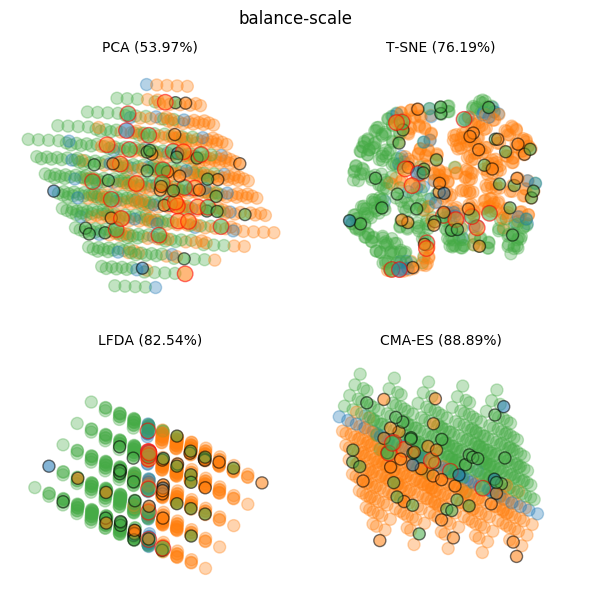

In [7]:
for datasetName, alldata in resultsByDataset.items():
    N = sum([1 if x in alldata else 0 for x,y in methodTitles])
    
    fig, axes = startGraphing(datasetName, 2, N)
    for i, (method, title) in enumerate(methodTitles):
        
        if method not in alldata:
            continue
        
        data = alldata[method]
        plotScatter(axes[i],title,**data)

    print('{}/{}'.format(graphsDirectory, datasetName))
    endGraphing(fig, '{}/{}'.format(graphsDirectory, datasetName))